# 構造化データに対する機械学習モデルのトレーニング：エンドツーエンドのサンプル

このデモでは以下のステップをカバーします。
- データのインポート
- Seabornとmatplotlibによるデータの可視化
- データセットに対して機械学習モデルをトレーニングする際、ハイパーパラメーター探索を並列実行
- MLflowによるハイパーパラメーター探索結果の確認
- ベストモデルをMLflowに登録
- Spark UDFを用いて登録済みモデルを別のデータセットに適用
- 低レーテンシーリクエストに対応するためのモデルサービング

この例では、ワインの物理化学的特性に基づいて、ポルトガルの"Vinho Verde"ワインの品質を予測するモデルを構築します。

この例では、UCI機械学習リポジトリのデータ[*
Modeling wine preferences by data mining from physicochemical properties*](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub) [Cortez et al., 2009]を活用します。

## 要件
このノートブックではDatabricks MLランタイムが必要です。Databrikcs 7.3 LTS ML以前を利用している場合には、CloudPickleライブラリをアップデートする必要があります。この場合、Cmd 3の`%pip install`コマンドのコメントを解除して実行してください。

<table>
  <tr><th>作者</th><th>Databricks Japan</th></tr>
  <tr><td>日付</td><td>2021/08/10</td></tr>
  <tr><td>バージョン</td><td>1.0</td></tr>
  <tr><td>クラスター</td><td>8.3ML</td></tr>
</table>

<img style="margin-top:25px;" src="https://sajpstorage.blob.core.windows.net/workshop20210205/databricks-logo-small-new.png" width="140">

## OSS MLflowとの違い

![](https://databricks.com/wp-content/uploads/2021/06/Table-1.png)

In [0]:
# Databrikcs 7.3 LTS ML以前を利用している場合にのみ以下のコマンドの実行が必要です。
#%pip install --upgrade cloudpickle

## データのインポート

このセクションでは、サンプルデータからpandasデータフレームにデータを読み込みます。

In [0]:
import pandas as pd

white_wine = pd.read_csv("/dbfs/databricks-datasets/wine-quality/winequality-white.csv", sep=";")
red_wine = pd.read_csv("/dbfs/databricks-datasets/wine-quality/winequality-red.csv", sep=";")

ワインが赤ワインか白ワインかを示す"is_red"カラムを追加して、二つのデータフレームを一つのデータセットにマージします。

In [0]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# カラム名から空白を削除
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [0]:
data.head()

Out[3]:

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


## データの可視化

モデルをトレーニングする前に、Seaborn、matplotlibを用いてデータを可視化します。

目的変数のqualityのヒストグラムをプロットします。

Out[4]:

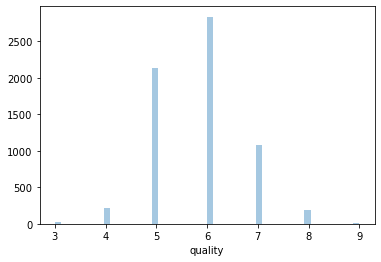

<matplotlib.axes._subplots.AxesSubplot at 0x7ff1244aeac0>

In [0]:
import seaborn as sns
sns.distplot(data.quality, kde=False)

qualityは3から9に正規分布しているように見えます。

quality >= 7のワインを高品質と定義します。

In [0]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

特徴量と2値ラベルの間の相関を見るにはボックスプロットが有用です。

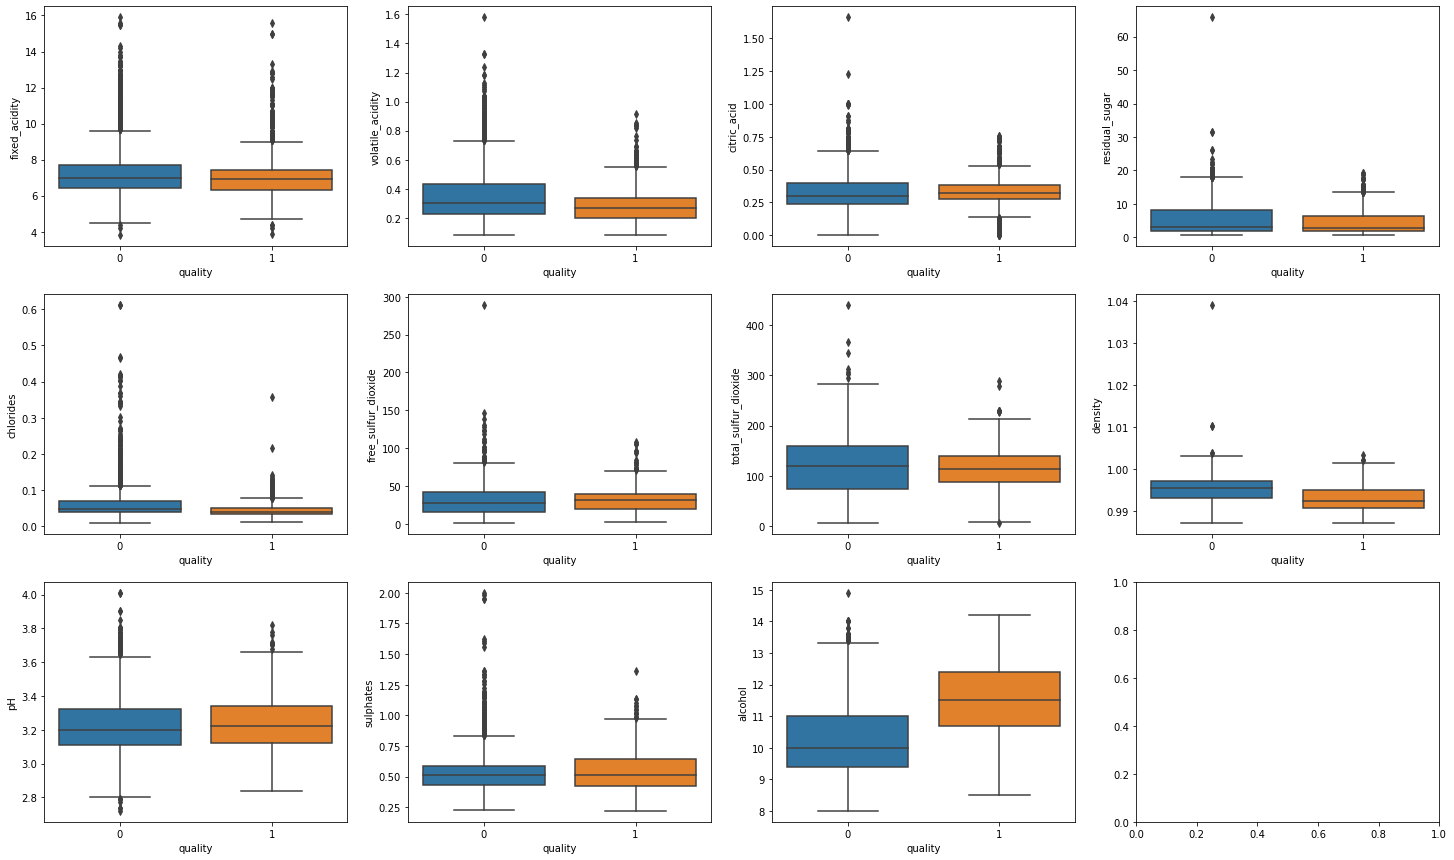

In [0]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # カテゴリ変数にボックスプロットは使用できません
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

上のボックスプロットから、いくつかの変数がqualityに対する単変量予測子として優れていることがわかります。
<br><br>
- alcoholのボックスプロットにおいては、高品質ワインのアルコール含有量の中央値は、低品質のワインの75%パーセンタイルよりも大きな値となっています。
- densityのボックスプロットにおいては、低品質ワインの密度は高品質ワインよりも高い値を示しています。密度は品質と負の相関があります。

## データの前処理

モデルのトレーニングの前に、欠損値のチェックを行い、データをトレーニングデータとバリデーションデータに分割します。

In [0]:
data.isna().any()

Out[7]: fixed_acidity False
volatile_acidity False
citric_acid False
residual_sugar False
chlorides False
free_sulfur_dioxide False
total_sulfur_dioxide False
density False
pH False
sulphates False
alcohol False
quality False
is_red False
dtype: bool

欠損値はありませんでした。

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=123)
X_train = train.drop(["quality"], axis=1)
X_test = test.drop(["quality"], axis=1)
y_train = train.quality
y_test = test.quality

## ベースラインモデルの構築

出力が2値であり、複数の変数間での相互関係がある可能性があることから、このタスクにはランダムフォレスト分類器が適しているように見えます。

以下のコードでは、scikit-learnを用いてシンプルな分類器を構築します。モデルの精度を追跡するためにMLflowを用い、後ほど利用するためにモデルを保存します。

In [0]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

# sklearnのRandomForestClassifierのpredictメソッドは、2値の分類結果(0、1)を返却します。
# 以下のコードでは、それぞれのクラスに属する確率を返却するpredict_probaを用いる、ラッパー関数SklearnModelWrapperを構築します。

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

  
# mlflow.start_runは、このモデルのパフォーマンスを追跡するための新規MLflowランを生成します。
# コンテキスト内で、使用されたパラメーターを追跡するためにmlflow.log_param、精度のようなメトリクスを追跡するために
# mlflow.log_metricを呼び出します。
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)

  # predict_probaは[prob_negative, prob_positive]を返却するので、出力を[:, 1]でスライスします。
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # メトリックとしてROC曲線のAUCを使用します。
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # モデルの入出力スキーマを定義するシグネチャをモデルとともに記録します。
  # モデルがデプロイされた際に、入力を検証するためにシグネチャが用いられます。
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflowにはモデルをサービングする際に用いられるconda環境を作成するユーティリティが含まれています。
  # 必要な依存関係がconda.yamlに保存され、モデルとともに記録されます。
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/databricks/python/lib/python3.8/site-packages/mlflow/models/signature.py:123: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
 inputs = _infer_schema(model_input)

サ二ティチェックとして、モデルによって出力される特徴量の重要度を確認します。

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

Out[10]:

,importance
alcohol,0.162047
density,0.115506
volatile_acidity,0.089138
chlorides,0.082570
pH,0.081632
citric_acid,0.081109
total_sulfur_dioxide,0.081001
sulphates,0.078901
residual_sugar,0.077866
free_sulfur_dioxide,0.076833


先ほどボックスプロットで見たように、品質を予測するのにアルコールと密度が重要であることがわかります。

MLflowにROC曲線のAUCを記録しました。右上の**Experiment**をクリックして、エクスペリメントランのサイドバーを表示します。

このモデルはAUC0.89を達成しました。

ランダムな分類器のAUCは0.5となり、それよりAUCが高いほど優れていると言えます。詳細は、[Receiver Operating Characteristic Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)を参照ください。

#### MLflowモデルレジストリにモデルを登録

モデルレジストリにモデルを登録することで、Databricksのどこからでもモデルを容易に参照できるようになります。

以下のセクションでは、どのようにプログラム上から操作をするのかを説明しますが、UIを用いてモデルを登録することもできます。"Create or register a model using the UI" ([AWS](https://docs.databricks.com/applications/machine-learning/manage-model-lifecycle/index.html#create-or-register-a-model-using-the-ui)|[Azure](https://docs.microsoft.com/azure/databricks/applications/machine-learning/manage-model-lifecycle/index#create-or-register-a-model-using-the-ui))を参照ください。

In [0]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [0]:
# モデルレジストリにモデルを登録します
model_name = "wine_quality_taka"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# モデル登録に数秒を要するので、待ち時間を挿入します。
time.sleep(15)

Successfully registered model 'wine_quality_taka'.
Created version '1' of model 'wine_quality_taka'.

Modelsページでモデルを確認できるはずです。Modelsページを表示するには、左のサイドバーでModelsアイコンをクリックします。

次に、このモデルをproductionに移行し、モデルレジストリからモデルをこのノートブックにロードします。

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

Out[14]: <ModelVersion: creation_timestamp=1628567118534, current_stage='Production', description='', last_updated_timestamp=1628567589441, name='wine_quality_taka', run_id='cf5120aad34e4539a006682a617a0964', run_link='', source='dbfs:/databricks/mlflow-tracking/72179715609078/cf5120aad34e4539a006682a617a0964/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='7459477216523290', version='1'>

Modelsページでは、モデルバージョンが`Production`ステージにあると表示されます。

これで、`models:/wine_quality/production`のパスでモデルを参照することができます。

In [0]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

# サニティチェック: この結果はMLflowで記録されたAUCと一致すべきです
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.888902759745664

## 新たなモデルを用いたエクスペリメント

ハイパーパラメーターチューニングを行わなくても、このランダムフォレストモデルはうまく動きました。

以下のコードでは、より精度の高いモデルをトレーニングするためにxgboostライブラリを使用します。HyperoptとSparkTrialsを用いて、複数のモデルを並列にトレーニングするために、ハイパーパラメーター探索を並列で処理します。上のコードと同様に、パラメーター設定、パフォーマンスをMLflowでトラッキングします。

In [0]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # トレーニングの再現性を確保するためにシードを設定します。
}

def train_model(params):
  # MLflowのオートロギングによって、ハイパーパラメーターとトレーニングしたモデルは自動的にMLflowに記録されます。
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)
    # xgbが評価メトリクスを追跡できるようにテストセットを渡します。XGBoostは、評価メトリクスに改善が見られなくなった際にトレーニングを中止します。
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(test, "test")], early_stopping_rounds=50)
    predictions_test = booster.predict(test)
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_metric('auc', auc_score)

    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)
    
    # fminがauc_scoreを最大化するようにlossに-1*auc_scoreを設定します。
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

# 並列度が高いほどスピードを改善できますが、ハイパーパラメータの探索において最適とは言えません。
# max_evalsの平方根が並列度の妥当な値と言えます。
spark_trials = SparkTrials(parallelism=10)

# "xgboost_models"という親のランの子ランとして、それぞれのハイパーパラメーターの設定が記録されるようにMLflowランのコンテキスト内でfminを実行します。
with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=96,
    trials=spark_trials, 
    rstate=np.random.RandomState(123)
  )

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/96 [00:00<?, ?trial/s, best loss=?] 1%| | 1/96 [00:11<18:10, 11.48s/trial, best loss: -0.9071897010077377] 2%|▏ | 2/96 [00:13<13:43, 8.76s/trial, best loss: -0.9134387201400085] 3%|▎ | 3/96 [00:19<12:18, 7.94s/trial, best loss: -0.9134387201400085] 5%|▌ | 5/96 [00:22<08:58, 5.91s/trial, best loss: -0.9149843298949462] 7%|▋ | 7/96 [00:24<06:38, 4.48s/trial, best loss: -0.918529720886657]  8%|▊ | 8/96 [00:27<05:55, 4.04s/trial, best loss: -0.918529720886657] 9%|▉ | 9/96 [00:28<04:32, 3.13s/trial, best loss: -0.918529720886657] 10%|█ | 10/96 [00:31<04:31, 3.15s/trial, best loss: -0.918529720886657] 12%|█▎ | 12/96 [00:38<04:35, 3.28s/trial, best loss: -0.918529720886657] 14%|█▎ | 13/96 [00:39<03:35, 2.60s/trial, best loss: -0.918529720886657] 15%|█▍ | 14/96 [00:41<02:56, 2.15s/trial, best loss: -0.918529720886657] 16%|█▌ | 15/96 [00:48<04:59, 3.70s/trial, best loss: -0.918529720886657] 17%|█▋ | 16/96 [00:56<06:48, 5.11s/trial, best loss: -0.9189981595354609] 18%|█▊ | 17/96 [00:57<05:08, 3.91s/trial, best loss: -0.9189981595354609] 19%|█▉ | 18/96 [01:02<05:16, 4.06s/trial, best loss: -0.9230690578438506] 20%|█▉ | 19/96 [01:06<05:13, 4.08s/trial, best loss: -0.9230690578438506] 21%|██ | 20/96 [01:09<04:47, 3.78s/trial, best loss: -0.9230690578438506] 23%|██▎ | 22/96 [01:11<03:39, 2.97s/trial, best loss: -0.9230690578438506] 24%|██▍ | 23/96 [01:15<04:02, 3.33s/trial, best loss: -0.9230690578438506] 25%|██▌ | 24/96 [01:17<03:32, 2.95s/trial, best loss: -0.9230690578438506] 26%|██▌ | 25/96 [01:22<04:15, 3.59s/trial, best loss: -0.9230690578438506] 27%|██▋ | 26/96 [01:30<05:25, 4.65s/trial, best loss: -0.9230690578438506] 28%|██▊ | 27/96 [01:35<05:31, 4.80s/trial, best loss: -0.9230690578438506] 30%|███ | 29/96 [01:39<04:26, 3.98s/trial, best loss: -0.9230690578438506] 31%|███▏ | 30/96 [01:44<04:47, 4.35s/trial, best loss: -0.9230690578438506] 32%|███▏ | 31/96 [01:47<04:19, 3.98s/trial, best loss: -0.9230690578438506] 34%|███▍ | 33/96 [01:50<03:24, 3.25s/trial, best loss: -0.9230690578438506] 35%|███▌ | 34/96 [01:58<04:54, 4.75s/trial, best loss: -0.9230690578438506] 36%|███▋ | 35/96 [02:02<04:19, 4.25s/trial, best loss: -0.9230690578438506] 38%|███▊ | 36/96 [02:05<03:54, 3.91s/trial, best loss: -0.9230690578438506] 39%|███▊ | 37/96 [02:07<03:19, 3.38s/trial, best loss: -0.9230690578438506] 40%|███▉ | 38/96 [02:10<03:11, 3.29s/trial, best loss: -0.9230690578438506] 41%|████ | 39/96 [02:14<03:21, 3.54s/trial, best loss: -0.9230690578438506] 43%|████▎ | 41/96 [02:16<02:33, 2.79s/trial, best loss: -0.9230690578438506] 44%|████▍ | 42/96 [02:21<03:10, 3.52s/trial, best loss: -0.9230690578438506] 46%|████▌ | 44/96 [02:26<02:48, 3.23s/trial, best loss: -0.9230690578438506] 47%|████▋ | 45/96 [02:31<03:00, 3.55s/trial, best loss: -0.9230690578438506] 48%|████▊ | 46/96 [02:38<03:50, 4.62s/trial, best loss: -0.9230690578438506] 49%|████▉ | 47/96 [02:40<03:10, 3.88s/trial, best loss: -0.9230690578438506] 51%|█████ | 49/96 [02:41<02:14, 2.87s/trial, best loss: -0.9230690578438506] 52%|█████▏ | 50/96 [02:43<02:05, 2.72s/trial, best loss: -0.9230690578438506] 53%|█████▎ | 51/96 [02:50<02:49, 3.76s/trial, best loss: -0.9230690578438506] 54%|█████▍ | 52/96 [02:57<03:29, 4.77s/trial, best loss: -0.9230690578438506] 55%|█████▌ | 53/96 [02:58<02:38, 3.68s/trial, best loss: -0.9230690578438506] 56%|█████▋ | 54/96 [03:03<02:52, 4.11s/trial, best loss: -0.9230690578438506] 58%|█████▊ | 56/96 [03:05<02:07, 3.19s/tri

#### MLflowを用いて結果を確認

Experiment Runsサイドバーを開いて、ランを参照します。メニューを表示するために、下向き矢印の隣にあるDateをクリックし`auc`を選択し、aucメトリックの順でランを並び替えます。一番高いaucは0.92となっています。ベースラインモデルを上回りました！

MLflowはそれぞれのランのパフォーマンスメトリクスとパラメーターをトラッキングします。Experiment Runsサイドバーの一番上にある右上向きの矢印アイコン<img src="https://docs.databricks.com/_static/images/icons/external-link.png"/>をクリックすることで、MLflowランの一覧に移動することができます。

次に、どのようにハイパーパラメータの選択がAUCと相関しているのかを見てみましょう。"+"アイコンをクリックして、親のランを展開し、親以外の全てのランを選択し、"Compare"をクリックします。Parallel Coordinates Plotを選択します。

メトリックに対するパラメーターのインパクトを理解するために、Parallel Coordinates Plotは有用です。プロットの右上にあるピンクのスライダーをドラッグすることで、AUCの値のサブセット、対応するパラメーターの値をハイライトすることができます。以下のプロットでは、最も高いAUCの値をハイライトしています。

<img src="https://docs.databricks.com/_static/images/mlflow/end-to-end-example/parallel-coordinates-plot.png"/>

最もパフォーマンスの良かったランの全てが、`reg_lambda`と`learning_rate`において低い値を示していることに注意してください。

これらのパラメーターに対してより低い値を探索するために、さらなるハイパーパラメーターチューニングを実行することもできますが、ここではシンプルにするために、そのステップをデモに含めていません。

それぞれのハイパーパラメーターの設定において生成されたモデルを記録するためにMLflowを用いました。以下のコードでは、最も高いパフォーマンスを示したランを検索し、モデルレジストリにモデルを登録します。

In [0]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.9230690578438506

#### MLflowモデルレジストリのProductionステージにある`wine_quality_taka`モデルを更新

はじめに、`wine_quality_taka`という名前でベースラインモデルをモデルレジストリに保存しました。さらに精度の高いモデルができましたので、`wine_quality_taka`を更新します。

In [0]:
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

# モデル登録に数秒を要するので、待ち時間を挿入します。
time.sleep(15)

Registered model 'wine_quality_taka' already exists. Creating a new version of this model...
Created version '2' of model 'wine_quality_taka'.

左のサイドバーで**Models**をクリックし、`wine_quality_taka`に二つのバージョンが存在することを確認します。

以下のコードで新バージョンをproductionに移行します。

In [0]:
# 古いモデルバージョンをアーカイブします。
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Archived"
)

# 新しいモデルバージョンをProductionに昇格します。
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Production"
)

Out[19]: <ModelVersion: creation_timestamp=1628570763176, current_stage='Production', description='', last_updated_timestamp=1628570885591, name='wine_quality_taka', run_id='76f2a8847faa49959b1492e7ff198ca6', run_link='', source='dbfs:/databricks/mlflow-tracking/72179715609078/76f2a8847faa49959b1492e7ff198ca6/artifacts/model', status='READY', status_message='', tags={}, user_id='7459477216523290', version='2'>

load_modelを呼び出すクライアントは新たなモデルを受け取ります。

In [0]:
# このコードは上の"ベースラインモデルの構築"と同じものです。新たなモデルを利用するためにクライアント側での変更は不要です！
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.9230690578438506

## バッチ推論

新たなデータのコーパスに対してモデルを評価したいというシナリオは数多く存在します。例えば、新たなデータバッチを手に入れたり、同じデータコーパスに対して二つのモデルを比較することなどが考えられます。

以下のコードでは、並列に処理を行うためにSparkを用い、Deltaテーブルに格納されたデータに対してモデルの評価を行います。

In [0]:
# 新たなデータコーパスをシミュレートするために、既存のX_trainデータをDeltaテーブルに保存します。
# 実際の環境では、本当に新たなデータバッチとなります。
spark_df = spark.createDataFrame(X_train)
# Deltaテーブルの保存先(適宜変更してください)
table_path = "dbfs:/tmp/takaakiyayoidatabrickscom/delta/wine_data"
# すでにコンテンツが存在する場合には削除します
dbutils.fs.rm(table_path, True)
spark_df.write.format("delta").save(table_path)

モデルをSparkのUDF(ユーザー定義関数)としてロードし、Deltaテーブルに適用できるようにします。

In [0]:
import mlflow.pyfunc

apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}/production")

In [0]:
# 新規データをDeltaから読み込みます
new_data = spark.read.format("delta").load(table_path)

In [0]:
display(new_data)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_red
7.8,0.39,0.26,9.9,0.059000000000000004,33.0,181.0,0.9955,3.04,0.42,10.9,0
6.6,0.725,0.09,5.5,0.11699999999999999,9.0,17.0,0.99655,3.35,0.49,10.8,1
5.8,0.36,0.5,1.0,0.127,63.0,178.0,0.9921200000000001,3.1,0.45,9.7,0
9.3,0.36,0.39,1.5,0.08,41.0,55.0,0.9965200000000001,3.47,0.73,10.9,1
7.5,0.18,0.31,11.7,0.051,24.0,94.0,0.997,3.19,0.44,9.5,0
8.0,0.4,0.33,7.7,0.034,27.0,98.0,0.9935,3.18,0.41,12.2,0
6.0,0.26,0.33,4.35,0.04,15.0,80.0,0.98934,3.29,0.5,12.7,0
8.8,0.55,0.04,2.2,0.11900000000000001,14.0,56.0,0.9962,3.21,0.6,10.9,1
6.4,0.29,0.3,6.5,0.209,62.0,156.0,0.9947799999999999,3.1,0.4,9.4,0
7.3,0.13,0.31,2.3,0.054000000000000006,22.0,104.0,0.9924,3.24,0.92,11.5,0


In [0]:
from pyspark.sql.functions import struct

# 新規データにモデルを適用します
udf_inputs = struct(*(X_train.columns.tolist()))

new_data = new_data.withColumn(
  "prediction",
  apply_model_udf(udf_inputs)
)

In [0]:
# それぞれの行には予測結果が紐づけられています。
# xgboostの関数はデフォルトでは確率を出力せず、予測結果が[0, 1]に限定されないことに注意してください。
display(new_data)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_red,prediction
7.8,0.39,0.26,9.9,0.059000000000000004,33.0,181.0,0.9955,3.04,0.42,10.9,0,0.001875649788416922
6.6,0.725,0.09,5.5,0.11699999999999999,9.0,17.0,0.99655,3.35,0.49,10.8,1,0.019253870472311974
5.8,0.36,0.5,1.0,0.127,63.0,178.0,0.9921200000000001,3.1,0.45,9.7,0,0.0012200977653265
9.3,0.36,0.39,1.5,0.08,41.0,55.0,0.9965200000000001,3.47,0.73,10.9,1,0.011752982623875141
7.5,0.18,0.31,11.7,0.051,24.0,94.0,0.997,3.19,0.44,9.5,0,0.9037631154060364
8.0,0.4,0.33,7.7,0.034,27.0,98.0,0.9935,3.18,0.41,12.2,0,0.9303209185600281
6.0,0.26,0.33,4.35,0.04,15.0,80.0,0.98934,3.29,0.5,12.7,0,0.04740304499864578
8.8,0.55,0.04,2.2,0.11900000000000001,14.0,56.0,0.9962,3.21,0.6,10.9,1,6.927406648173928E-4
6.4,0.29,0.3,6.5,0.209,62.0,156.0,0.9947799999999999,3.1,0.4,9.4,0,5.81351516302675E-4
7.3,0.13,0.31,2.3,0.054000000000000006,22.0,104.0,0.9924,3.24,0.92,11.5,0,0.9371384382247925


## モデルサービング

低レーテンシーでの予測を行うようにモデルを運用するためには、MLflowのモデルサービング([AWS](https://docs.databricks.com/applications/mlflow/model-serving.html)|[Azure](https://docs.microsoft.com/azure/databricks/applications/mlflow/model-serving))を利用して、モデルをエンドポイントにデプロイします。

以下のコードでは、どのようにREST APIを用いてデプロイしたモデルから予測結果を得るのかを説明します。

モデルのエンドポイントにリクエストするためには、Databricksのトークンが必要です。(右上のプロファイルアイコンの下の)User Settingページでトークンを生成することができます。

トークンなど機密性の高い情報はノートブックに記述すべきではありません。シークレットに保存するようにしてください。

[Databricksにおけるシークレットの管理 \- Qiita](https://qiita.com/taka_yayoi/items/338ef0c5394fe4eb87c0)

In [0]:
import os

# 事前にCLIでシークレットにトークンを登録しておきます
token = dbutils.secrets.get("demo-token-takaaki.yayoi", "token")

os.environ["DATABRICKS_TOKEN"] = token

左のサイドバーで**Models**をクリックし、登録されているワインモデルに移動します。servingタブをクリックし、**Enable Serving**をクリックします。

次に、**Call The Model**で、リクエストを送信するためのPythonコードスニペットを表示するために**Python**ボタンをクリックします。コードをこのノートブックにコピーします。次のセルと同じようなコードになるはずです。

Databricksの外からリクエストするために、このトークンを利用することもできます。

In [0]:
import os
import requests
import numpy as np
import pandas as pd

def create_tf_serving_json(data):
  return {'inputs': {name: data[name].tolist() for name in data.keys()} if isinstance(data, dict) else data.tolist()}

def score_model(dataset):
  url = 'https://e2-demo-west.cloud.databricks.com/model/wine_quality_taka/2/invocations'
  headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}'}
  data_json = dataset.to_dict(orient='split') if isinstance(dataset, pd.DataFrame) else create_tf_serving_json(dataset)
  response = requests.request(method='POST', headers=headers, url=url, json=data_json)
  if response.status_code != 200:
    raise Exception(f'Request failed with status {response.status_code}, {response.text}')
  return response.json()

エンドポイントから得られるモデルの予測結果と、ローカルでモデルを評価した結果は一致すべきです。

In [0]:
# モデルサービングは、比較的小さいデータバッチにおいて低レーテンシーで予測するように設計されています。
num_predictions = 5
served_predictions = score_model(X_test[:num_predictions])
model_evaluations = model.predict(X_test[:num_predictions])
# トレーニングしたモデルとデプロイされたモデルの結果を比較します。
pd.DataFrame({
  "Model Prediction": model_evaluations,
  "Served Model Prediction": served_predictions,
})

Out[33]:

,Model Prediction,Served Model Prediction
0,0.025937,0.025937
1,0.039204,0.039204
2,0.827066,0.827066
3,0.045013,0.045013
4,0.756959,0.756959


## モデルのアクセス権管理

MLflowモデルレジストリに登録されたMLflowモデルに対しては、6つのレベルのアクセス権を設定できます:**No Permissions**(アクセス権なし)、**Read**(読み取り)、**Edit**(編集)、**Manage Staging Versions**(ステージングバージョンの管理)、**Manage Production Versions**(プロダクションバージョンの管理)、**Manage**(管理)です。

以下のテーブルに権限ごとにできることを示します。

| できること| No Permissions | Read | Edit | Manage Staging Versions | Manage Production Versions | Manage | 
|:--|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|モデルの作成   |x   |x   |x   |x   |x   |x   |
|モデル詳細、バージョン、ステージ変更リクエスト、アクティビティ、アーティファクトダウンロードURIの表示   |   | x  |x   |x   |x   |x   |
|モデルバージョンステージ変更依頼   |   | x  | x  | x  | x  | x  | 
|新バージョンのモデルの追加   |   |   | x  | x  | x  | x  | 
|モデルの記述更新   |   |   |  x | x  |  x |  x | 
|モデルのステージング状態の変更   |   |   |   |  x(None/Archived/Stagingのみ) | x  |  x |   
|モデルのステージング状態変更リクエストの承認・却下   |   |   |   |  x(None/Archived/Stagingのみ) |   x| x  |   
|モデルのステージング状態変更リクエストのキャンセル(リクエストのキャンセルを参照)   |   |   |   |   |   |  x |   
|アクセス権の変更   |   |   |   |   |   | x  |   
|モデル名の変更   |   |   |   |   |   | x  |   
|モデル及びバージョンの削除   |   |   |   |   |   | x  |   

##### リクエストのキャンセル
> - ステージング状態変更リクエストをした本人は、リクエストをキャンセルできます。

# END